In [1]:
# !pip install xgboost
# !pip install lightgbm

In [2]:
# Packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [3]:
df = pd.read_csv('/workspaces/IDS721_FInal_Team_Project_SP23_Du_Wang/00_source_data/heart_2020_cleaned.csv')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


### Data Preprocessing

In [4]:
X = df.drop('HeartDisease', axis=1)
# encode Yes and No to 1 and 0
X = X.replace({'Yes': 1, 'No': 0})
# encode categorical variables into one-hot encoding
X = pd.get_dummies(X)
y = df['HeartDisease']
y = y.replace({'Yes': 1, 'No': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8886)


In [5]:
# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(xgb.score(X_test, y_test)))

Accuracy of XGBoost classifier on test set: 0.91


In [6]:
# check the feature importance
xgb.feature_importances_

array([0.00345136, 0.01764946, 0.00464227, 0.04643323, 0.00491967,
       0.00364248, 0.10765817, 0.00324037, 0.00340417, 0.00553029,
       0.02208441, 0.01058598, 0.02103482, 0.        , 0.07287716,
       0.05507043, 0.05423883, 0.05071912, 0.03037118, 0.01905202,
       0.01017569, 0.00583917, 0.00471414, 0.01685821, 0.035248  ,
       0.04133091, 0.04494524, 0.00431339, 0.00393456, 0.00454972,
       0.00435382, 0.0041357 , 0.01053855, 0.0057898 , 0.06145472,
       0.00321392, 0.00372566, 0.07741807, 0.0243981 , 0.01852215,
       0.0320337 , 0.04590128], dtype=float32)

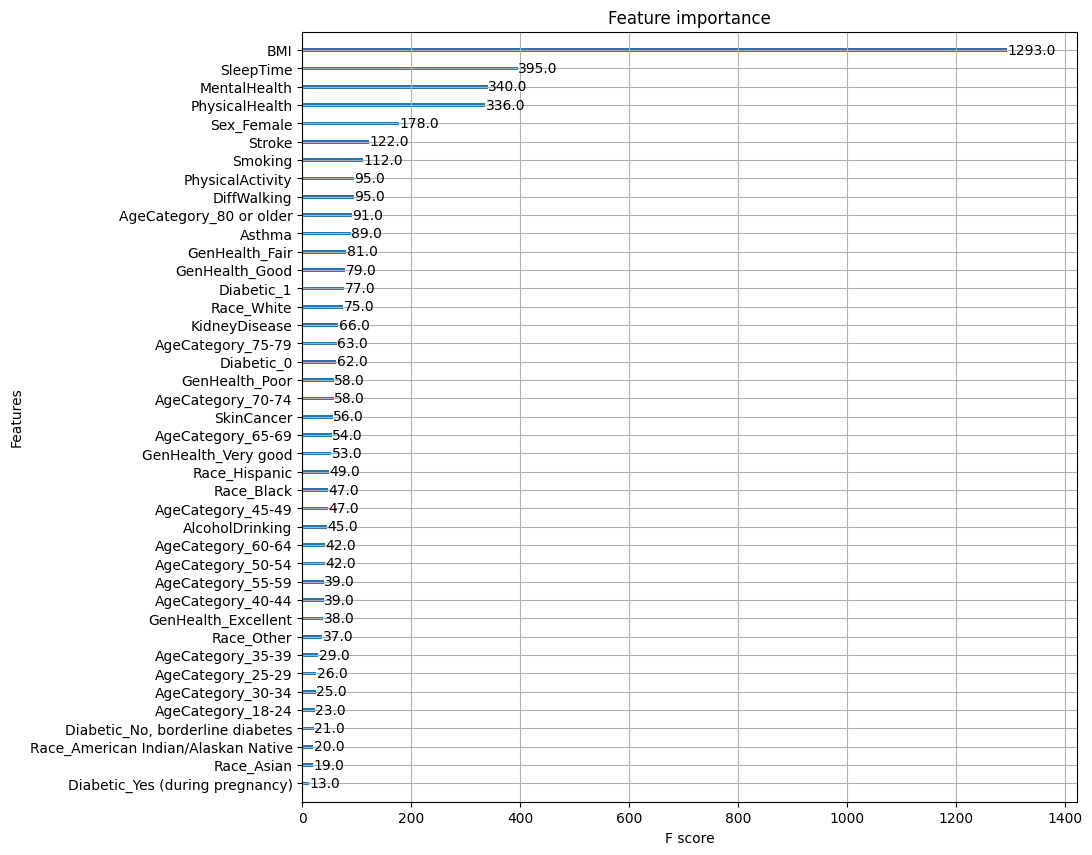

In [7]:
# plot the feature importance
from xgboost import plot_importance
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = [10, 10]
to_save = plot_importance(xgb)
pyplot.show()

# save the plot into 20_intermediate_files
to_save.figure.savefig('/workspaces/IDS721_FInal_Team_Project_SP23_Du_Wang/20_intermediate_files/xgb_feature_importance.png')

AUC: 0.844


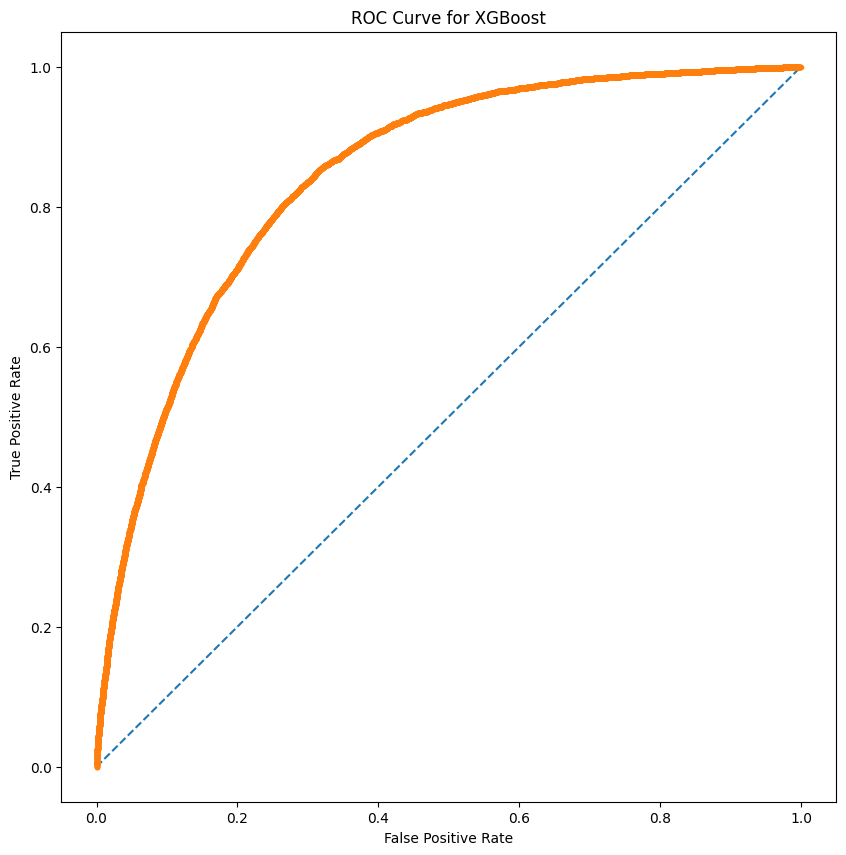

In [8]:
# get the roc curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# predict probabilities
probs = xgb.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
pyplot.rcParams['figure.figsize'] = [10, 10]
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
pyplot.title('ROC Curve for XGBoost')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the plot
pyplot.show()

f1=0.160 auc=0.346 ap=0.346


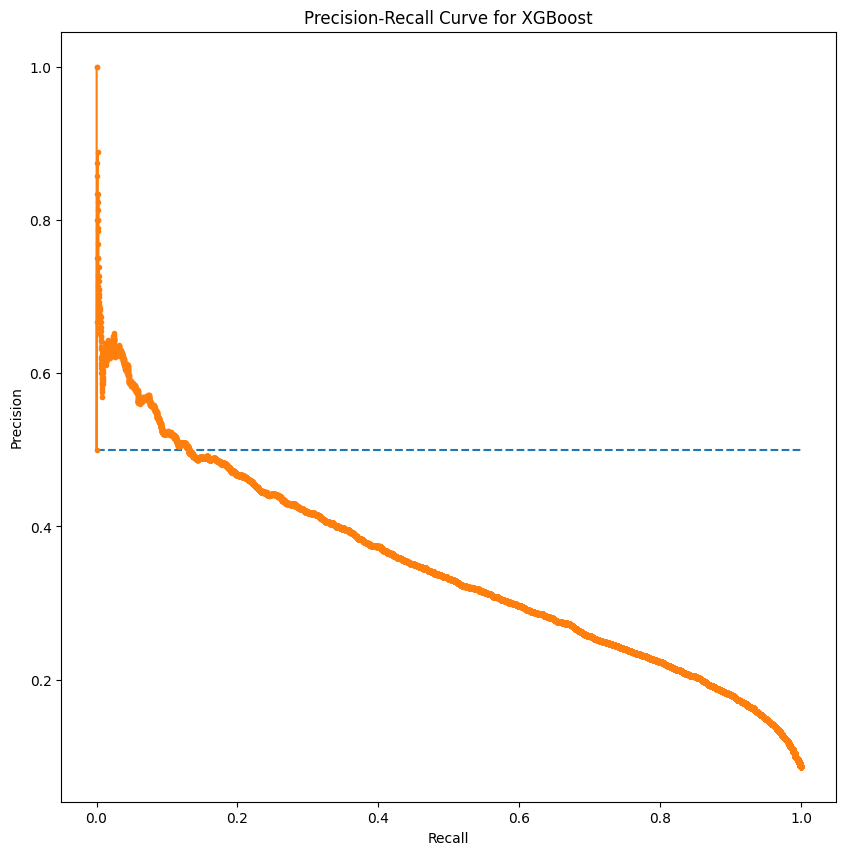

In [9]:
# get precision-recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
# predict probabilities
probs = xgb.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = xgb.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, probs)
# calculate F1 score
f1 = f1_score(y_test, yhat)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
from sklearn.metrics import average_precision_score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.rcParams['figure.figsize'] = [10, 10]
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
pyplot.title('Precision-Recall Curve for XGBoost')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the plot
pyplot.show()

In [11]:
# use randomized search to find the best parameters
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint
# define model
model = XGBClassifier()
# define search space
space = dict()
space['n_estimators'] = randint(100, 1000)
space['max_depth'] = randint(1, 10)
space['learning_rate'] = uniform(0.001, 0.1)
# define search
search = RandomizedSearchCV(model, space, n_iter=100, scoring='accuracy', n_jobs=-1, random_state=8886)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
# get the best model
best_model = result.best_estimator_
# make predictions
yhat = best_model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % accuracy)